In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torchvision.models import densenet121, DenseNet121_Weights
from torch.utils.data import DataLoader, Sampler
from AdaIN import AdaIN

In [2]:
dn = densenet121(weights = DenseNet121_Weights.DEFAULT)
print(dn)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
style_path = "style/sketch.png"
image_path = "content/avril.jpg"

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(256),
    transforms.ToTensor()
])

#coco content
train_content_dataset = datasets.ImageFolder(
    root= "../coco",             
    transform=transform
)

#wikiart
train_style_dataset = datasets.ImageFolder(
    root= "../archive",             
    transform=transform
)

train_content_loader = DataLoader(train_content_dataset, batch_size=1, shuffle=True)
train_style_loader = DataLoader(train_style_dataset, batch_size=1, shuffle=True)

Epoch: 1
[1000/20000] content=0.0774 style=0.0191 total=0.096487
[2000/20000] content=0.0486 style=0.0109 total=0.059485
[3000/20000] content=0.0423 style=0.0105 total=0.052802
[4000/20000] content=0.0384 style=0.0096 total=0.047991
[5000/20000] content=0.0362 style=0.0094 total=0.045622
[6000/20000] content=0.0340 style=0.0089 total=0.042975
[7000/20000] content=0.0324 style=0.0085 total=0.040940
[8000/20000] content=0.0317 style=0.0086 total=0.040238
[9000/20000] content=0.0306 style=0.0084 total=0.039044
[10000/20000] content=0.0305 style=0.0085 total=0.038944
[11000/20000] content=0.0298 style=0.0084 total=0.038252
[12000/20000] content=0.0289 style=0.0081 total=0.036988
[13000/20000] content=0.0284 style=0.0081 total=0.036509
[14000/20000] content=0.0280 style=0.0080 total=0.036034
[15000/20000] content=0.0279 style=0.0082 total=0.036079
[16000/20000] content=0.0277 style=0.0081 total=0.035760
[17000/20000] content=0.0269 style=0.0078 total=0.034712
[18000/20000] content=0.0268 st

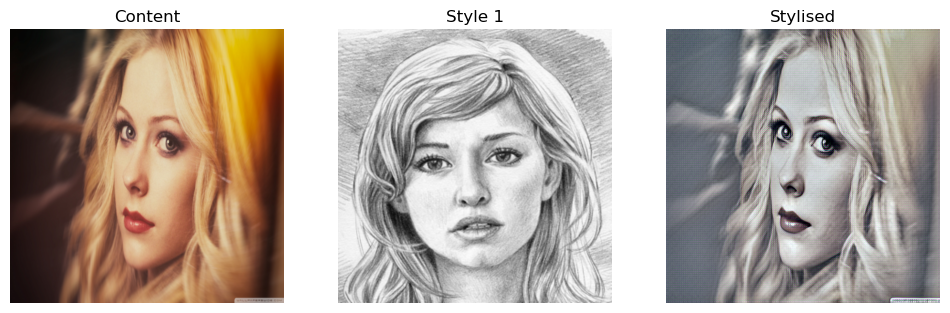

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.596, '2387.378 ms')

In [4]:

encoder = nn.Sequential(*list(dn.features.children())[:7])
# print(encoder)

decoder = nn.Sequential(    
            nn.ReflectionPad2d(1),
            nn.Conv2d(512, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3),
    
        )



dnModel = AdaIN()
dnModel.uploadEncoder(encoder)
dnModel.uploadDecoder(decoder)
dnModel.setup()
dnModel.epochTraining(train_content_loader, train_style_loader, "dense", steps = 20000, epoch = 5,style_weight = 10, content_weight = 10)
dnModel.fit(image_path,[style_path])
dnModel.pipeline()
dnModel.displayImages()
dnModel.evaluate()

In [5]:
encoder_new = nn.Sequential(*list(dn.features.children())[:9])
print(encoder_new)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(

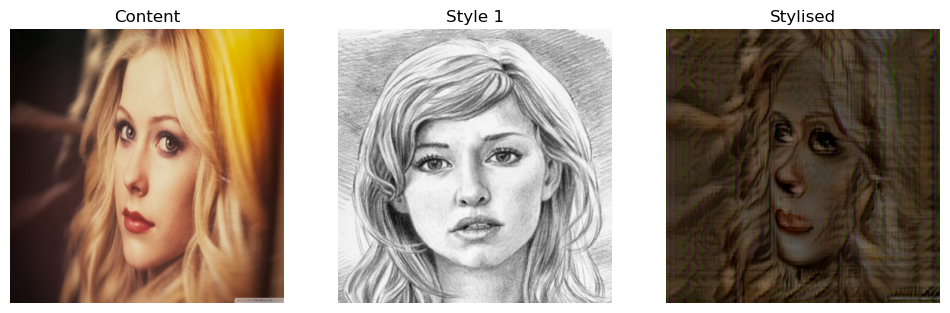

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.732, '2726.306 ms')

In [6]:
decoder_new = nn.Sequential(    
            nn.ReflectionPad2d(1),
            nn.Conv2d(1024, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(128, 64, 3),
            nn.ReLU(inplace=True),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(inplace=True),

            
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, 3),
        )



dnModel2 = AdaIN(prebuild_decoder = "dense_8_layer_5.pth")
dnModel2.uploadEncoder(encoder_new)
dnModel2.uploadDecoder(decoder_new)
dnModel2.setup()
# dnModel2.epochTraining(train_content_loader, train_style_loader, "dense.pth", steps = 20000, epoch = 10,style_weight = 10, content_weight = 10)
dnModel2.fit(image_path,[style_path])
dnModel2.pipeline()
dnModel2.displayImages()
dnModel2.evaluate()

Epoch: 1
[1000/20000] content=0.0330 style=0.0646 total=0.097693
[2000/20000] content=0.0345 style=0.0558 total=0.090370
[3000/20000] content=0.0347 style=0.0534 total=0.088183
[4000/20000] content=0.0348 style=0.0506 total=0.085424
[5000/20000] content=0.0362 style=0.0517 total=0.087921
[6000/20000] content=0.0363 style=0.0496 total=0.085886
[7000/20000] content=0.0346 style=0.0459 total=0.080524
[8000/20000] content=0.0356 style=0.0471 total=0.082739
[9000/20000] content=0.0359 style=0.0476 total=0.083583
[10000/20000] content=0.0353 style=0.0456 total=0.080933
[11000/20000] content=0.0354 style=0.0454 total=0.080889
[12000/20000] content=0.0343 style=0.0423 total=0.076577
[13000/20000] content=0.0347 style=0.0423 total=0.077023
[14000/20000] content=0.0348 style=0.0425 total=0.077266
[15000/20000] content=0.0351 style=0.0427 total=0.077840
[16000/20000] content=0.0348 style=0.0423 total=0.077142
[17000/20000] content=0.0356 style=0.0427 total=0.078330
[18000/20000] content=0.0350 st

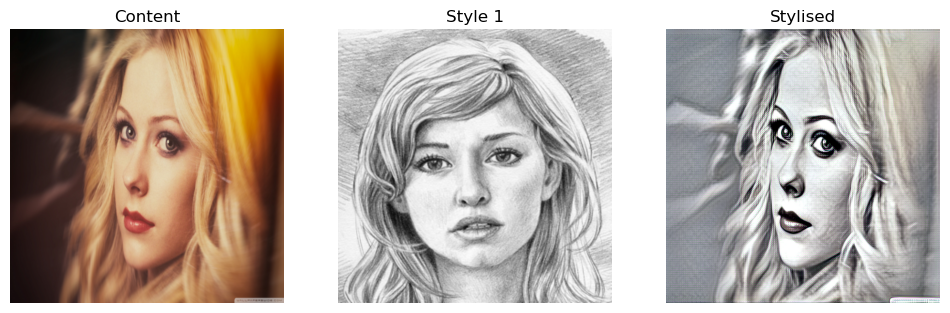

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/anaconda3/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


(0.666, '784.240 ms')

In [7]:
#Heavy styled image
dnModelStyled = AdaIN()
dnModelStyled.uploadEncoder(encoder)
dnModelStyled.uploadDecoder(decoder)
dnModelStyled.epochTraining(train_content_loader, train_style_loader, "dense_strong_style", steps = 20000, epoch = 10,style_weight = 100, content_weight = 10)
dnModelStyled.fit(image_path,[style_path])
dnModelStyled.pipeline()
dnModelStyled.displayImages()
dnModelStyled.evaluate()